## A Comparative Analysis of Normalization Techniques and SAR/LAM Models
In this notebook, we dive into the heart of brain connectivity analysis. We will compare how different normalization techniques affect the performance of SAR and LAM models, seeking the method that yields the most meaningful insights into the brain's structure. The ultimate goal is to determine the best normalization approach for modeling the intricate web of human functional brain connectivity and provide a deeper understanding of how our brain regions communicate.

In [19]:
# All the tools you need in this notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from yanat import core as cor
import seaborn as sns
from yanat import utils as ut
import warnings
warnings.filterwarnings("ignore")
from matplotlib import font_manager
from matplotlib import font_manager
from visual_config import *
for font in font_manager.findSystemFonts("figures/Atkinson_Typeface/"):
    font_manager.fontManager.addfont(font)
set_visual_style()
from typing import Union, Optional, Tuple, Callable


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Human Connectome Dataset 

In [20]:
data = scipy.io.loadmat("human_connectome_dataset/Consensus_Connectomes.mat",  
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,) 

Content of this dataset:

LauConsensus
  Matrices:

    [0]: Connectivity Matrix

    [1]: Fiber Lengths

    [2]: Functional Connectivity Matrix

    [3]: Coordinates
    
    [4]: Labels and Modules

In [21]:
res_parcellation = 2 # This is a multiresolution connectome. 
connectivity = data["LauConsensus"]["Matrices"][res_parcellation][0]
fc = data["LauConsensus"]["Matrices"][res_parcellation][2] 
fiber_lengths = data["LauConsensus"]["Matrices"][res_parcellation][1]
coordinates = data["LauConsensus"]["Matrices"][res_parcellation][3]
labels = data["LauConsensus"]["Matrices"][res_parcellation][4][:, 0]
fc_modules = data["LauConsensus"]["Matrices"][res_parcellation][4][:, 2]

NOTE: For now, we choose this value as res_parcellation = 2, but as you will see in the other notebook of my project, I tried to show the effect of this value on the models and the outputs they produce. 

The codes in the below just the Brute-force way to look at it as a network: (That's why it's normal if you can't make sense of the code. )

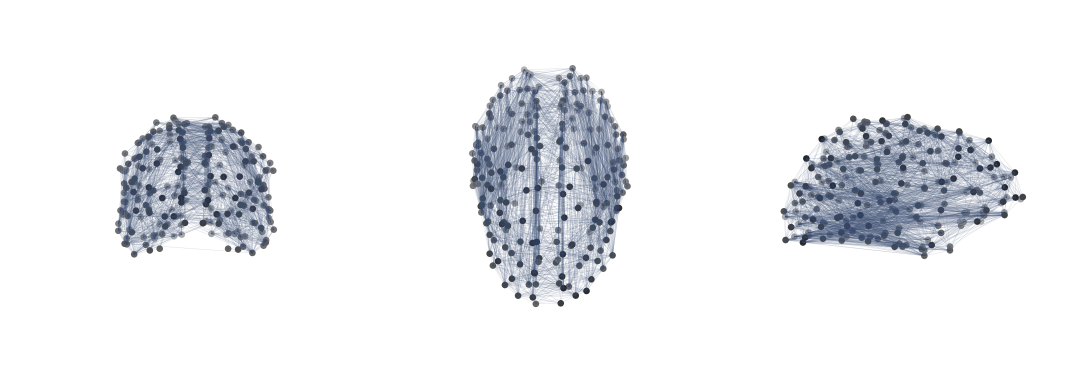

In [22]:
SEED = 2023
sagittal = (0, 180)
axial = (90, 180) # these are actually wrong but they do the job so I'm not changing them!
coronal = (0, 90)
bottom = (-90, 0)
size = 80
scatter_kw_network = dict(alpha=1, linewidths=0, edgecolors=HALF_BLACK)
scatter_kw = dict(alpha=1, linewidths=0.7, edgecolors=HALF_BLACK)
fig, axes = plt.subplot_mosaic(
    [["A", "B", "C"]], figsize=HALF_PAGE, subplot_kw=dict(projection="3d"), dpi=150
)
for i in range(connectivity.shape[0]):
    for j in range(i, connectivity.shape[1]):
        if connectivity[i, j] != 0:
            axes["A"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )
            axes["B"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )
            axes["C"].plot(
                [coordinates[i, 0], coordinates[j, 0]],
                [coordinates[i, 1], coordinates[j, 1]],
                [coordinates[i, 2], coordinates[j, 2]],
                c=NIGHT_BLUE,
                alpha=0.2 + connectivity[i, j],
                linewidth=0.2,
            )

brain_plotter(
    np.array(coordinates[:, 0]),
    coordinates,
    axes["A"],
    view=sagittal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
brain_plotter(
    np.flip(np.array(coordinates[:, 2])),
    coordinates,
    axes["B"],
    view=axial,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)
brain_plotter(
    np.flip(np.array(coordinates[:, 1])),
    coordinates,
    axes["C"],
    view=coronal,
    size=10,
    cmap=monochrome,
    scatter_kwargs=scatter_kw_network,
)

fig.tight_layout(pad=0.1)
# plt.savefig(f"results/structural_brain_network.png", dpi=600, bbox_inches="tight")